In [1]:
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
import os
import argparse
import numpy as np
import pandas as pd
from keras.models import load_model
from keras.callbacks import ModelCheckpoint
from keras import backend as K
from data import setup_training_data, connect

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
import pandas as pd
from keras.models import Model
from keras.layers import Input, Dense

In [4]:
def build_model(input_size):
    x = Input(shape=(input_size,))
    layer1 = Dense(25, activation='relu')(x)
    layer2 = Dense(10)(layer1)
    layer3 = Dense(35)(layer2)
    layer4 = Dense(10)(layer3)
    layer5 = Dense(25, activation=None)(layer4)
    layer6 = Dense(1)(layer5)
    model = Model(x, layer6)
    model.compile(optimizer='adam',
                  loss='mean_absolute_error',
                  metrics=['mape'])
    return model

In [5]:
def load_aiden_features(tablename, limit=None):
    host = "knxairflowc01"
    user = "gcl"
    db = "gcl"
    connection, meta = connect(user, "2H2P5PFcdSQY", db, host=host)
    limit = 'limit {}'.format(limit) if limit else ''
    results = meta.tables[tablename]
    columns = [row.name for row in results.c if not row.name.startswith('actual_')]
    execution = connection.execute('select {} from {} {}'.format(', '.join(columns), tablename, limit))
    records = [row for row in execution]
    aiden_features = pd.DataFrame.from_records(records, columns=columns)
    execution.close()
    return aiden_features

In [6]:
df = load_aiden_features('aiden_features_v2')

In [7]:
df.head()

,unit_id,date_id,price,year,month,day_of_week,day_of_year,day_of_month,estimated_cost,estimated_cost_dif,...,ll_pct,ll_pct_dif,ll_pct_ma_3,ll_pct_ma_7,ll_pct_ma_14,seven_day_pace_pct,seven_day_pace_pct_dif,seven_day_pace_pct_ma_3,seven_day_pace_pct_ma_7,seven_day_pace_pct_ma_14
0,753.0,2017-02-22,2.659,2017.0,February,Wednesday,53.0,22.0,2.1379,0.0142,...,-0.1382,0.0210,-0.256967,-0.160043,-0.145114,0.0103,-0.0085,0.021467,-0.021057,-0.045007
1,753.0,2017-02-23,2.649,2017.0,February,Thursday,54.0,23.0,2.1315,-0.0064,...,-0.0897,0.0485,-0.215700,-0.147157,-0.149364,0.0071,-0.0032,0.018000,-0.008186,-0.039593
2,753.0,2017-02-24,2.649,2017.0,February,Friday,55.0,24.0,2.1601,0.0286,...,-0.2357,-0.1460,-0.129033,-0.144000,-0.157593,-0.0490,-0.0561,0.012067,0.005486,-0.036764
3,753.0,2017-02-25,2.649,2017.0,February,Saturday,56.0,25.0,2.1438,-0.0163,...,-0.1184,0.1173,-0.154533,-0.191600,-0.159850,-0.0886,-0.0396,-0.010533,0.003014,-0.034693
4,753.0,2017-02-26,2.649,2017.0,February,Sunday,57.0,26.0,2.1438,0.0000,...,-0.2185,-0.1001,-0.147933,-0.193271,-0.152750,-0.1005,-0.0119,-0.043500,-0.007971,-0.036807


In [8]:
for c in sorted(df.columns):
    print(c)

date_id
day_of_month
day_of_week
day_of_year
estimated_cost
estimated_cost_dif
estimated_cost_ma_14
estimated_cost_ma_3
estimated_cost_ma_7
estimated_margin
estimated_margin_dif
estimated_margin_ma_14
estimated_margin_ma_3
estimated_margin_ma_7
ll_pct
ll_pct_dif
ll_pct_ma_14
ll_pct_ma_3
ll_pct_ma_7
month
opis_avg
opis_avg_dif
opis_avg_ma_14
opis_avg_ma_3
opis_avg_ma_7
price
seven_day_pace_pct
seven_day_pace_pct_dif
seven_day_pace_pct_ma_14
seven_day_pace_pct_ma_3
seven_day_pace_pct_ma_7
unit_id
year


In [10]:
exclude_cols = ['price',
                'unit_id',
                'date_id']
training_data = setup_training_data(df, 'price',
                                    [col for col in df.columns if col not in exclude_cols])

In [11]:
store = 348
val_frac = 0.02

In [12]:
testing_data = {}
i = int(training_data[store][1].shape[0] * (1 - float(val_frac)))
testing_data[store] = (training_data[store][0][i:], training_data[store][1][i:])
x, y = training_data[store]

In [13]:
num_features = len(df.columns) - len(exclude_cols)
file_path = 'ModelName.h5'
model = build_model(num_features)
model.save(file_path)

In [14]:
model = load_model('ModelName.h5')

checkpoint = ModelCheckpoint(
    '{}-checkpoint.h5'.format(model),
    verbose=1,
    monitor='val_mean_absolute_percentage_error',
    save_best_only=True,
    mode='auto')

session = K.get_session()
for layer in model.layers:
    if hasattr(layer, 'kernel_initializer'):
        layer.kernel.initializer.run(session=session)

history = model.fit(
    x,
    np.log(y),
    epochs=1000,
    verbose=0,
    validation_split=float(val_frac),
    shuffle=True,
    callbacks=[checkpoint]).history

losses = {key: history[key] for key in history}

model.save('{}_store-{}.h5'.format(model, store))
pd.DataFrame(losses).to_csv('{}_store-{}_losses.csv'.format(model, store))

X_test = testing_data[store][0]
try:
    predictions = np.exp(model.predict(X_test).flatten())
except TypeError:
    raise Exception(
        'ERROR: Looks like this model may have not been trained yet.'
        'Please ensure model is trained for predictions with `-t` flag.')


Epoch 00001: val_mean_absolute_percentage_error improved from inf to 285.51828, saving model to <keras.engine.training.Model object at 0x7f676e786b38>-checkpoint.h5

Epoch 00002: val_mean_absolute_percentage_error improved from 285.51828 to 122.32731, saving model to <keras.engine.training.Model object at 0x7f676e786b38>-checkpoint.h5

Epoch 00003: val_mean_absolute_percentage_error did not improve from 122.32731

Epoch 00004: val_mean_absolute_percentage_error did not improve from 122.32731

Epoch 00005: val_mean_absolute_percentage_error did not improve from 122.32731

Epoch 00006: val_mean_absolute_percentage_error did not improve from 122.32731

Epoch 00007: val_mean_absolute_percentage_error improved from 122.32731 to 45.95910, saving model to <keras.engine.training.Model object at 0x7f676e786b38>-checkpoint.h5

Epoch 00008: val_mean_absolute_percentage_error did not improve from 45.95910

Epoch 00009: val_mean_absolute_percentage_error did not improve from 45.95910

Epoch 00010:


Epoch 00099: val_mean_absolute_percentage_error did not improve from 1.06631

Epoch 00100: val_mean_absolute_percentage_error did not improve from 1.06631

Epoch 00101: val_mean_absolute_percentage_error did not improve from 1.06631

Epoch 00102: val_mean_absolute_percentage_error did not improve from 1.06631

Epoch 00103: val_mean_absolute_percentage_error did not improve from 1.06631

Epoch 00104: val_mean_absolute_percentage_error did not improve from 1.06631

Epoch 00105: val_mean_absolute_percentage_error did not improve from 1.06631

Epoch 00106: val_mean_absolute_percentage_error did not improve from 1.06631

Epoch 00107: val_mean_absolute_percentage_error did not improve from 1.06631

Epoch 00108: val_mean_absolute_percentage_error did not improve from 1.06631

Epoch 00109: val_mean_absolute_percentage_error did not improve from 1.06631

Epoch 00110: val_mean_absolute_percentage_error did not improve from 1.06631

Epoch 00111: val_mean_absolute_percentage_error did not improve


Epoch 00203: val_mean_absolute_percentage_error did not improve from 0.74338

Epoch 00204: val_mean_absolute_percentage_error did not improve from 0.74338

Epoch 00205: val_mean_absolute_percentage_error did not improve from 0.74338

Epoch 00206: val_mean_absolute_percentage_error did not improve from 0.74338

Epoch 00207: val_mean_absolute_percentage_error did not improve from 0.74338

Epoch 00208: val_mean_absolute_percentage_error did not improve from 0.74338

Epoch 00209: val_mean_absolute_percentage_error did not improve from 0.74338

Epoch 00210: val_mean_absolute_percentage_error did not improve from 0.74338

Epoch 00211: val_mean_absolute_percentage_error did not improve from 0.74338

Epoch 00212: val_mean_absolute_percentage_error did not improve from 0.74338

Epoch 00213: val_mean_absolute_percentage_error did not improve from 0.74338

Epoch 00214: val_mean_absolute_percentage_error did not improve from 0.74338

Epoch 00215: val_mean_absolute_percentage_error did not improve


Epoch 00305: val_mean_absolute_percentage_error did not improve from 0.56347

Epoch 00306: val_mean_absolute_percentage_error improved from 0.56347 to 0.52332, saving model to <keras.engine.training.Model object at 0x7f676e786b38>-checkpoint.h5

Epoch 00307: val_mean_absolute_percentage_error did not improve from 0.52332

Epoch 00308: val_mean_absolute_percentage_error did not improve from 0.52332

Epoch 00309: val_mean_absolute_percentage_error did not improve from 0.52332

Epoch 00310: val_mean_absolute_percentage_error did not improve from 0.52332

Epoch 00311: val_mean_absolute_percentage_error did not improve from 0.52332

Epoch 00312: val_mean_absolute_percentage_error did not improve from 0.52332

Epoch 00313: val_mean_absolute_percentage_error did not improve from 0.52332

Epoch 00314: val_mean_absolute_percentage_error did not improve from 0.52332

Epoch 00315: val_mean_absolute_percentage_error did not improve from 0.52332

Epoch 00316: val_mean_absolute_percentage_error did


Epoch 00410: val_mean_absolute_percentage_error did not improve from 0.52332

Epoch 00411: val_mean_absolute_percentage_error did not improve from 0.52332

Epoch 00412: val_mean_absolute_percentage_error did not improve from 0.52332

Epoch 00413: val_mean_absolute_percentage_error did not improve from 0.52332

Epoch 00414: val_mean_absolute_percentage_error did not improve from 0.52332

Epoch 00415: val_mean_absolute_percentage_error did not improve from 0.52332

Epoch 00416: val_mean_absolute_percentage_error did not improve from 0.52332

Epoch 00417: val_mean_absolute_percentage_error did not improve from 0.52332

Epoch 00418: val_mean_absolute_percentage_error did not improve from 0.52332

Epoch 00419: val_mean_absolute_percentage_error did not improve from 0.52332

Epoch 00420: val_mean_absolute_percentage_error did not improve from 0.52332

Epoch 00421: val_mean_absolute_percentage_error did not improve from 0.52332

Epoch 00422: val_mean_absolute_percentage_error did not improve


Epoch 00519: val_mean_absolute_percentage_error did not improve from 0.52332

Epoch 00520: val_mean_absolute_percentage_error did not improve from 0.52332

Epoch 00521: val_mean_absolute_percentage_error did not improve from 0.52332

Epoch 00522: val_mean_absolute_percentage_error did not improve from 0.52332

Epoch 00523: val_mean_absolute_percentage_error did not improve from 0.52332

Epoch 00524: val_mean_absolute_percentage_error did not improve from 0.52332

Epoch 00525: val_mean_absolute_percentage_error did not improve from 0.52332

Epoch 00526: val_mean_absolute_percentage_error did not improve from 0.52332

Epoch 00527: val_mean_absolute_percentage_error did not improve from 0.52332

Epoch 00528: val_mean_absolute_percentage_error did not improve from 0.52332

Epoch 00529: val_mean_absolute_percentage_error did not improve from 0.52332

Epoch 00530: val_mean_absolute_percentage_error did not improve from 0.52332

Epoch 00531: val_mean_absolute_percentage_error did not improve


Epoch 00628: val_mean_absolute_percentage_error did not improve from 0.52332

Epoch 00629: val_mean_absolute_percentage_error did not improve from 0.52332

Epoch 00630: val_mean_absolute_percentage_error did not improve from 0.52332

Epoch 00631: val_mean_absolute_percentage_error did not improve from 0.52332

Epoch 00632: val_mean_absolute_percentage_error did not improve from 0.52332

Epoch 00633: val_mean_absolute_percentage_error did not improve from 0.52332

Epoch 00634: val_mean_absolute_percentage_error did not improve from 0.52332

Epoch 00635: val_mean_absolute_percentage_error did not improve from 0.52332

Epoch 00636: val_mean_absolute_percentage_error did not improve from 0.52332

Epoch 00637: val_mean_absolute_percentage_error did not improve from 0.52332

Epoch 00638: val_mean_absolute_percentage_error did not improve from 0.52332

Epoch 00639: val_mean_absolute_percentage_error did not improve from 0.52332

Epoch 00640: val_mean_absolute_percentage_error did not improve


Epoch 00734: val_mean_absolute_percentage_error did not improve from 0.52332

Epoch 00735: val_mean_absolute_percentage_error did not improve from 0.52332

Epoch 00736: val_mean_absolute_percentage_error did not improve from 0.52332

Epoch 00737: val_mean_absolute_percentage_error did not improve from 0.52332

Epoch 00738: val_mean_absolute_percentage_error did not improve from 0.52332

Epoch 00739: val_mean_absolute_percentage_error did not improve from 0.52332

Epoch 00740: val_mean_absolute_percentage_error did not improve from 0.52332

Epoch 00741: val_mean_absolute_percentage_error did not improve from 0.52332

Epoch 00742: val_mean_absolute_percentage_error did not improve from 0.52332

Epoch 00743: val_mean_absolute_percentage_error did not improve from 0.52332

Epoch 00744: val_mean_absolute_percentage_error did not improve from 0.52332

Epoch 00745: val_mean_absolute_percentage_error did not improve from 0.52332

Epoch 00746: val_mean_absolute_percentage_error did not improve


Epoch 00841: val_mean_absolute_percentage_error did not improve from 0.52332

Epoch 00842: val_mean_absolute_percentage_error did not improve from 0.52332

Epoch 00843: val_mean_absolute_percentage_error did not improve from 0.52332

Epoch 00844: val_mean_absolute_percentage_error did not improve from 0.52332

Epoch 00845: val_mean_absolute_percentage_error did not improve from 0.52332

Epoch 00846: val_mean_absolute_percentage_error did not improve from 0.52332

Epoch 00847: val_mean_absolute_percentage_error did not improve from 0.52332

Epoch 00848: val_mean_absolute_percentage_error did not improve from 0.52332

Epoch 00849: val_mean_absolute_percentage_error did not improve from 0.52332

Epoch 00850: val_mean_absolute_percentage_error did not improve from 0.52332

Epoch 00851: val_mean_absolute_percentage_error did not improve from 0.52332

Epoch 00852: val_mean_absolute_percentage_error did not improve from 0.52332

Epoch 00853: val_mean_absolute_percentage_error did not improve


Epoch 00950: val_mean_absolute_percentage_error did not improve from 0.52332

Epoch 00951: val_mean_absolute_percentage_error did not improve from 0.52332

Epoch 00952: val_mean_absolute_percentage_error did not improve from 0.52332

Epoch 00953: val_mean_absolute_percentage_error did not improve from 0.52332

Epoch 00954: val_mean_absolute_percentage_error did not improve from 0.52332

Epoch 00955: val_mean_absolute_percentage_error did not improve from 0.52332

Epoch 00956: val_mean_absolute_percentage_error did not improve from 0.52332

Epoch 00957: val_mean_absolute_percentage_error did not improve from 0.52332

Epoch 00958: val_mean_absolute_percentage_error did not improve from 0.52332

Epoch 00959: val_mean_absolute_percentage_error did not improve from 0.52332

Epoch 00960: val_mean_absolute_percentage_error did not improve from 0.52332

Epoch 00961: val_mean_absolute_percentage_error did not improve from 0.52332

Epoch 00962: val_mean_absolute_percentage_error did not improve

In [15]:
preds = pd.Series(predictions)

In [16]:
test_trunc = int(training_data[store][1].shape[0] * (1 - float(val_frac)))
X_test = df[(df.unit_id == store)].iloc[test_trunc:]
X_test['predictions'] = preds.values

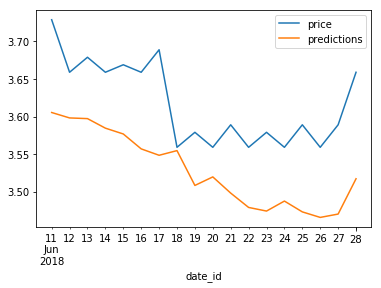

In [17]:
temp = X_test[['date_id', 'price', 'predictions']].set_index('date_id')
temp.plot()

In [18]:
X_test['aiden_margin'] = X_test.predictions - X_test.estimated_cost

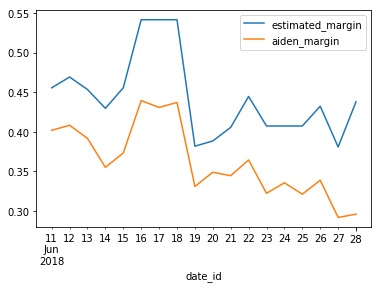

In [19]:
temp = X_test[['date_id', 'estimated_margin', 'aiden_margin']].set_index('date_id')
temp.plot()

In [ ]:
junk = pd.read_csv('../sandbox/data/store_errors.csv', header=None)

In [ ]:
junk.sort_values(by=[1], ascending=True)